<h1>Forecasting the 1950's Brazilian GDP - The ARIMA Model</h1>

In this notebook I present a very useful approach to analyze Time Series data: the **A**uto**r**egressive **I**ntegrated **M**oving **A**verage (**ARIMA**) model.

I chose to forecast the 1950's Brazilian GDP because during/after that decade the Brazilian economy became more complex and a pure ARIMA model would be a poor model to forecast the following years of the Brazilian economy. However, it does a decent job modeling the Brazilian GDP during the first half of the 20th century.

<h2>Importing the libraries</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller


%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

<h2>Importing the Data</h2>

Here I import the dataset that I'm going to analyze in this notebook. I chose to use The Brazilian GDP series (1900 - 2018) with values updated to 2010's BRL currency as made available in http://www.ipeadata.gov.br, as _"PIB - preços de mercado (preços 2010)"_, at 22/02/2020.

In [2]:
dataset = pd.read_csv('BR PIB 1900-2018.csv')

<h2>Data Preparation</h2>

Some data preparation before the analysis.

In [3]:
dataset.describe()

,Data,PIB - preços de mercado (preços 2010) - R$ de 2010 - Instituto Brasileiro de Geografia e Estatística- Sistema de Contas Nacionais (IBGE/SCN Anual) - SCN10_PIBP10,Unnamed: 2
count,119.000000,1.190000e+02,0.0
mean,1959.000000,1.132983e+06,NaN
std,34.496377,1.328683e+06,NaN
min,1900.000000,2.170338e+04,NaN
25%,1929.500000,7.776446e+04,NaN
50%,1959.000000,3.930461e+05,NaN
75%,1988.500000,2.108525e+06,NaN
max,2018.000000,4.263020e+06,NaN


Ok. So we have three columns: the first one with the year, the second with the GDP and the third one with NaN values. 

I'll rename the first and second columns, filter the dataset to work only with the years previous to the fifthies, and I'll drop the third column.

In [4]:
dataset.drop('Unnamed: 2', axis = 1, inplace = True)
dataset.columns = ['year', 'GDP']

In [5]:
#Parse strings to datetime type
dataset = dataset[dataset['year'] <= 1950].copy()
dataset['year'] = pd.to_datetime(dataset['year'], format='%Y').dt.year

In [6]:
dataset.tail()

,year,GDP
46,1946,163232.726811
47,1947,167150.312254
48,1948,183363.892543
49,1949,197482.912269
50,1950,210911.750303


Since I'm working with the GDP I'm creating the variable _GDP_Change_ to help us see the yearly percentual change in GDP.

In [7]:
dataset['GDP_Change'] = (dataset['GDP'] - dataset['GDP'].shift())/dataset['GDP'].shift() * 100

In [8]:
dataset.head()

,year,GDP,GDP_Change
0,1900,21703.379822,NaN
1,1901,24820.992393,14.364641
2,1902,24701.084217,-0.483092
3,1903,25180.716921,1.941748
4,1904,25540.441448,1.428571


<h2>Initial Visualization</h2>

Let's plot the data and see the yearly Brazilian GDP and its rate of change.

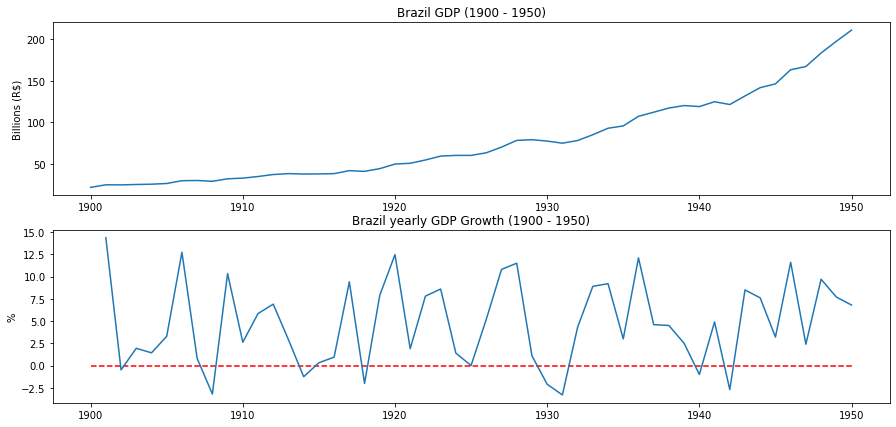

In [9]:
plt.subplot(2, 1, 1)
plt.plot(dataset['year'], dataset['GDP']/(10**3))
plt.title('Brazil GDP (1900 - 1950)')
plt.ylabel('Billions (R$)')

plt.subplot(2, 1, 2)
plt.plot(dataset['year'], dataset['GDP_Change'])
plt.title('Brazil yearly GDP Growth (1900 - 1950)')
plt.ylabel('%')
plt.hlines(y = 0, xmin = 1900, xmax = 1950, color = 'red', linestyle = 'dashed')

<h2>The ARIMA Model</h2>

The ARIMA Model is composed of three parameters: p, d, and q.
- p regards the number of lagged dependent variables in the model; It is expressed as AR(p);
- d is the number of times the series has to be differentiated to become stationary;
- q is the number of lagged errors terms in the regression that are influencing the current value of the dependent variable; It is commonly expressed as MA(q).

I'll start the ARIMA modeling by checking the series stationarity.

So I'll apply the **Augmented Dick-Fuller Test**: I'm basically looking for an ADF negative statistic with a p-value smaller than 0.05.
If the series is not stationary, I'll differentiate it until the series becomes stationary.

In [10]:
result = adfuller(dataset['GDP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.235615
p-value: 1.000000


In [11]:
result = adfuller(dataset['GDP'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.342278
p-value: 0.979203


In [12]:
result = adfuller(dataset['GDP'].diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.848555
p-value: 0.000000


Great. So I have to differentiate the series twice to make it stationary.

Now I'll try to identificate _p_ and _q_ by plotting the **Partial Autocorrelation** and the **Autocorrelation** functions.

The main idea here is to identificate the points outside the confidence interval as possible values for _p_ and _q_. 

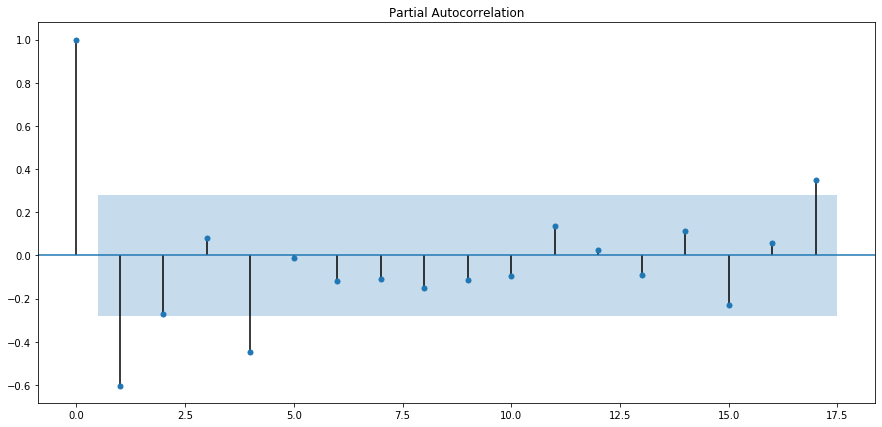

In [13]:
plot_pacf(dataset['GDP'].diff().diff().dropna());

The previous plot suggests that p could be 1, 4 or 17. However, I don't think that p = 17 is likely to make much sense here because, theoretically, this would imply that the GDP value of 17 years ago has a significant influence on the current GDP value. I'm not saying this is impossible, but I think it's more reasonable to work with a simpler model. So I'll only consider that p could be equal to 1 and to 4.

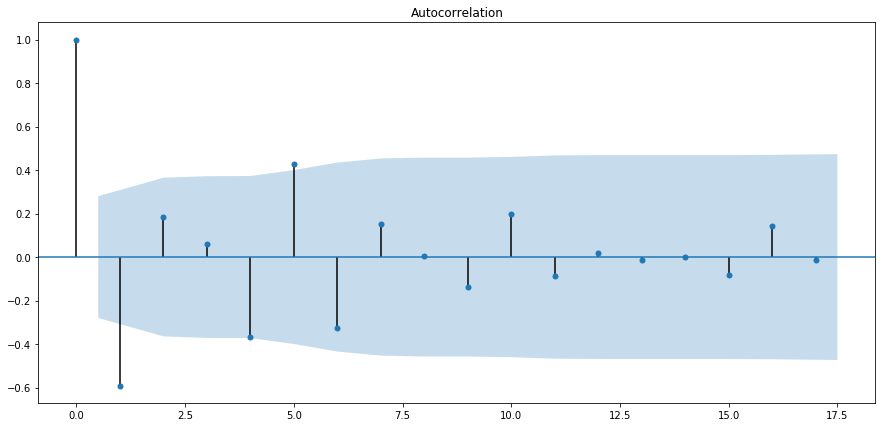

In [14]:
plot_acf(dataset['GDP'].diff().diff().dropna());

The autocorrelation plot suggests the value of q could be 1 or 5.

Ok. I'll also account for the possibility that p and q may be equal to zero. So I'm going to test the following ARIMA models:
- (0, 2, 0)
- (0, 2, 1)
- (0, 2, 5)
- (1, 2, 0)
- (1, 2, 1)
- (1, 2, 5)
- (4, 2, 0)
- (4, 2, 1)
- (4, 2, 5)

One good way to test and compare them is by comparing their AIC and BIC statistics. The smaller their values, the better the model is.

In [15]:
# fitting the models.
AR = [0, 1, 4]
MA = [0, 1, 5]
models = pd.DataFrame(columns = ['ARIMA', 'AIC', 'BIC'])
for p in range(len(AR)):
    for q in range(len(MA)):
        try:
            model = ARIMA(dataset['GDP'], order = (AR[p], 2, MA[q]))
            model_fit = model.fit(disp=0)
            values = pd.Series([(AR[p], 2, MA[q]), model_fit.aic, model_fit.bic], index = ['ARIMA', 'AIC', 'BIC'])
            models = models.append(values, ignore_index = True)
        except: pass
models

,ARIMA,AIC,BIC
0,"(0, 2, 0)",980.033743,983.817383
1,"(0, 2, 1)",956.434633,962.110094
2,"(0, 2, 5)",958.509211,971.751953
3,"(1, 2, 0)",961.172246,966.847707
4,"(1, 2, 1)",958.792614,966.359895
5,"(4, 2, 0)",952.471575,963.822497
6,"(4, 2, 1)",953.084566,966.327308


Checking the results we can see that the model with the smallest AIC is (4, 2, 0) and the model with the smallest BIC is (0, 2, 1). In these cases I always tend to prefer the simplest model because it implies less overfitting.

So let's take a closer look at the ARIMA (0, 2, 1) model. 

In [16]:
model = ARIMA(dataset['GDP'], order=(0,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D2.GDP   No. Observations:                   49
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -475.217
Method:                       css-mle   S.D. of innovations           3896.257
Date:                Sun, 23 Feb 2020   AIC                            956.435
Time:                        13:42:40   BIC                            962.110
Sample:                             2   HQIC                           958.588
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          220.3722    111.972      1.968      0.049       0.912     439.833
ma.L1.D2.GDP    -0.8242      0.130     -6.350      0.000      -1.079      -0.570
                                    Roots   

Let's take a look at the residuals.

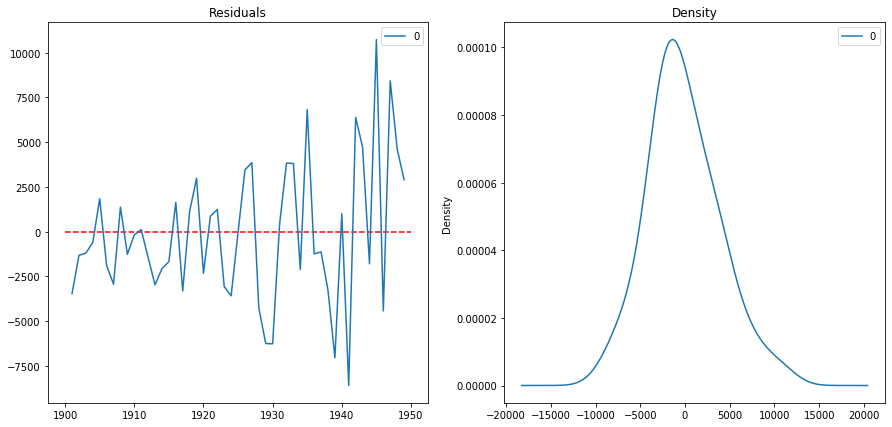

In [17]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.set_index(pd.Series(list(range(1901, 1950))), inplace = True)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0]).hlines(y = 0, xmin = 1900, xmax = 1950, color = 'red', linestyles = 'dashed')
#plot residuals density
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [18]:
residuals.describe()

,0
count,49.000000
mean,-150.489734
std,3949.551064
min,-8589.151941
25%,-2929.484144
50%,-1125.144126
75%,1844.232228
max,10734.154458


The residuals are not normally distributed and we can see that the closer they get to the fifthies the greater they become. This suggests us that we should be careful when using this model to make forecasts. A good improvement to this model could be the use of exogenous variables (transforming this ARIMA model into an ARIMAX model). However I'm not going into this step here, because this would surpass the purpose of this notebook. 

<h2>Forecasting the 1950's Brazilian GDP</h2>

Let's close this notebook by comparing this ARIMA model forecasts to the real Brazilian GDP values. And let's see how good it is to predict the next ten years of GDP growth.

In [19]:
dataset = pd.read_csv('BR PIB 1900-2018.csv')
dataset.drop('Unnamed: 2', axis = 1, inplace = True)
dataset.columns = ['year', 'GDP']
dataset = dataset[dataset['year'] <= 1960].copy()

In [20]:
next10 = model_fit.forecast(steps = 10, alpha = 0.05)
ci1 = []
ci2 = []
for i in range(len(next10[2])):
    ci1.append(next10[2][i][0])
    ci2.append(next10[2][i][1])

In [21]:
inSample = model_fit.predict(start=2, end=50, exog=None, typ='levels', dynamic=False)

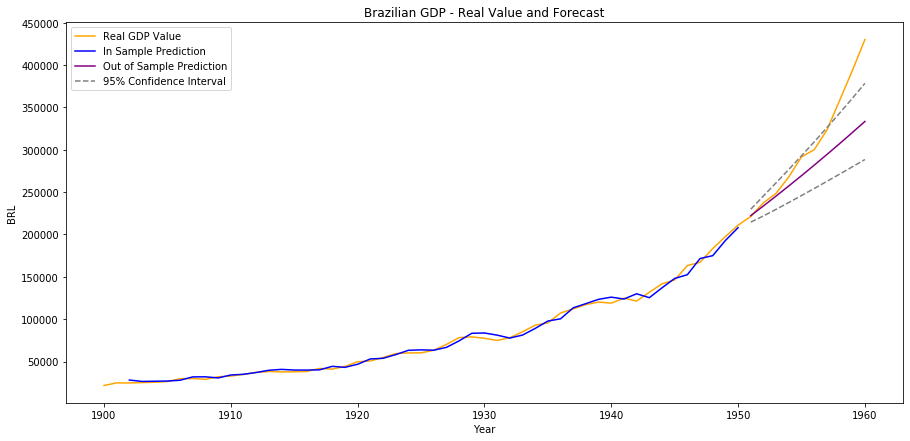

In [22]:
plt.plot(dataset['year'], dataset['GDP'], color = 'orange', label = 'Real GDP Value')
plt.plot(range(1902, 1951), inSample, color = 'blue', label = 'In Sample Prediction')
plt.plot(range(1951, 1961), next10[0], color = 'purple', label = 'Out of Sample Prediction')
plt.plot(range(1951, 1961), ci1, linestyle = 'dashed', color = 'gray')
plt.plot(range(1951, 1961), ci2, linestyle = 'dashed', color = 'gray', label = '95% Confidence Interval')
plt.title('Brazilian GDP - Real Value and Forecast')
plt.ylabel('BRL')
plt.xlabel('Year')
plt.legend()
plt.show()

In [23]:
for i in range(len(next10[0])):
    if dataset['GDP'][51 + i] > next10[2][i][1]:
        print('The Real GDP is outside of the 95% confidence interval at the year 195' + str(i) + ' and forward.')
        break

The Real GDP is outside of the 95% confidence interval at the year 1957 and forward.


The model seems to make some pretty straight forward predictions at the beggining of the out of sample prediction and them it gets worst as the time moves on. This is not a surprise since the model residuals get larger as we reach the end of the time series. Adding exogenous variables to the model and transforming it in an ARIMAX model could certainly help to improve it. However, the main goal of this notebook is to present the ARIMA model, and not to solve the Brazilian economy, so I'm  stopping here. ;)